In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#no scientific notation
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
sns.set()
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

In [2]:
#cars = pd.read_csv("vehicles.csv")
cars = pd.read_csv("vehicles_na_cleaned.csv")
cars = cars[(cars["price"] < 100000) & (cars["price"] > 100)]
cars = cars[
    (cars["odometer"] < 600000.0) & 
    ((cars["odometer"] > 100) | (cars["condition"] == "new"))
]

Looking at the data, some features might not be relevant for the analysis and I'll drop them so I don't have to load into memory redundant information. This should also decrease the size of the dataset on disk. I don't play to use any of these features in an initial analysis and eventually come back to them if the models aren't doing well at all.

In [ ]:
# only execute if working with initial file
# cars = cars.drop(columns=["id", "url", "VIN", "image_url", "county", "posting_date", "size"])

Some columns that have missing data, contain some information in the description column or in the model column. I'll try to backfill the data in case I will use these features later on.

In [3]:
def backfill_column(x, column_name, values):
    if pd.notna(x[column_name]):
        return x[column_name]
    
    for value in values:        
        if value in str(x["description"]) or value in str(x["model"]):
            return value

In [ ]:
manufacturer = set(cars["manufacturer"].astype(str).unique())
fuel = set(cars["fuel"].astype(str).unique())
color = set(cars["paint_color"].astype(str).unique())
car_type = set(cars["type"].astype(str).unique())
cars["manufacturer"] = cars.apply(lambda x: backfill_column(x, "manufacturer", manufacturer), axis=1)
cars["fuel"] = cars.apply(lambda x: backfill_column(x, "fuel", fuel), axis=1)
cars["paint_color"] = cars.apply(lambda x: backfill_column(x, "paint_color", color), axis=1)
cars["type"] = cars.apply(lambda x: backfill_column(x, "type", car_type), axis=1)

In [ ]:
cars = cars.drop(columns=["model", "description"])
cars = cars.dropna(subset=["lat", "long", "odometer", "year", "fuel", "transmission", "manufacturer"])

In [ ]:
cars.to_csv("vehicles_na_cleaned.csv")

### What's the percentage of missing values for each feature ? 

In [4]:
nr_cars = len(cars)
cars.isna().sum()/nr_cars

Unnamed: 0      0.000000
region          0.000000
region_url      0.000000
price           0.000000
year            0.000000
manufacturer    0.004138
condition       0.373658
cylinders       0.406562
fuel            0.001824
odometer        0.000000
title_status    0.017643
transmission    0.000000
drive           0.301553
type            0.149546
paint_color     0.234623
state           0.000000
lat             0.000000
long            0.000000
dtype: float64

County seems to be a useless column so will drop this as well. Size also seems to be present in less than 30% of observations so again will drop this as well. 

Some ideas about the columns, and how I plan to use them:
- ~~year - there are so few observations missing year that might not even worth bothering so will check if we can drop those observations whatsoever~~
- ~~model - cleaning up this column might definitely be worth the effort, I'll just do some basic replacements and see if the number of unique values decreases. 
This still gives me around 15000 unique values, even if I tried to simply substring up to 10 characters and do some replacements. Will see if this is worth using as a feature.~~
- condition, 40% missing, will replace missing with "unspecified"
- cylinders, 40% missing, will replace missing with "unspecified"
- ~~fuel - will drop the 7% of observations that don't have fuel~~
- ~~odometer - I feel like this is going to be fairly good predictor so will just round them to the nears 10s. Went down to 66 unique values this way.~~
- title status, 20% missing, will replace missing with "unspecified"
- ~~transmission - will drop the records with missing values~~
- drive, 30% missing, replace missing with "unspecified"
- ~~size, 70% missing, don't consider it as a feature~~
- type, 20% missing, replace or drop 
- paint_color - 30% replace with unknown
- ~~lat/long - I could replace the lat/long with the coordinates of the state biggest city, but for now will drop the missing ones as they are just 1%~~

In [5]:
cars["year"] = cars["year"].astype("int")
cars["lat"] = cars["lat"].astype("str")
cars["long"] = cars["long"].astype("str")

In [6]:
cars.describe()

,Unnamed: 0,price,year,odometer
count,367799.000000,367799.000000,367799.000000,367799.000000
mean,213286.986074,18891.287056,2011.331309,93583.522160
std,122846.208270,14319.214044,8.858698,63424.059415
min,27.000000,101.000000,1900.000000,0.000000
25%,108082.000000,7500.000000,2008.000000,39624.000000
50%,211283.000000,15590.000000,2013.000000,88107.000000
75%,319673.500000,27900.000000,2017.000000,135955.500000
max,426879.000000,99999.000000,2022.000000,590000.000000


It looks like it's safe to drop everything that has a price over 100000 as the sample contains a negligeable number of observations with that price. There are also 26000 observations with the price 0. The hypothesis here is that these are probably cars that are either given out for free or just bad data. Will remove them as well.

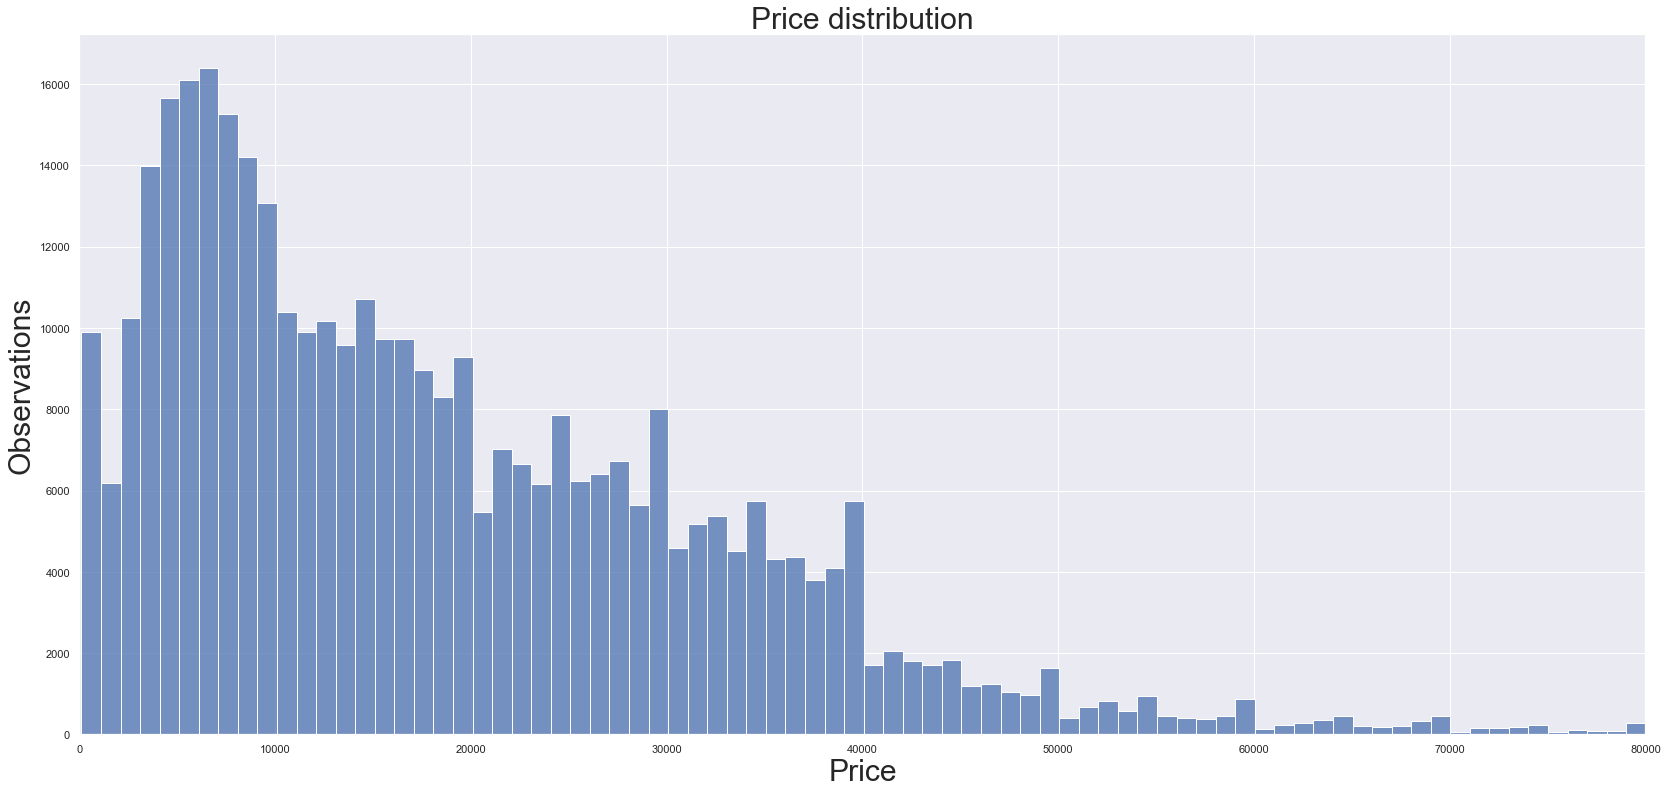

In [7]:
fig, ax = plt.subplots()
p = sns.histplot(cars["price"], bins=100)
p.axes.set_title("Price distribution",fontsize=30)
p.set_xlabel("Price",fontsize=30)
p.set_ylabel("Observations",fontsize=30)
plt.xlim([0, 80000])
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.show()

#### Distribution of prices by existing properties

Text(0, 0.5, 'Density')

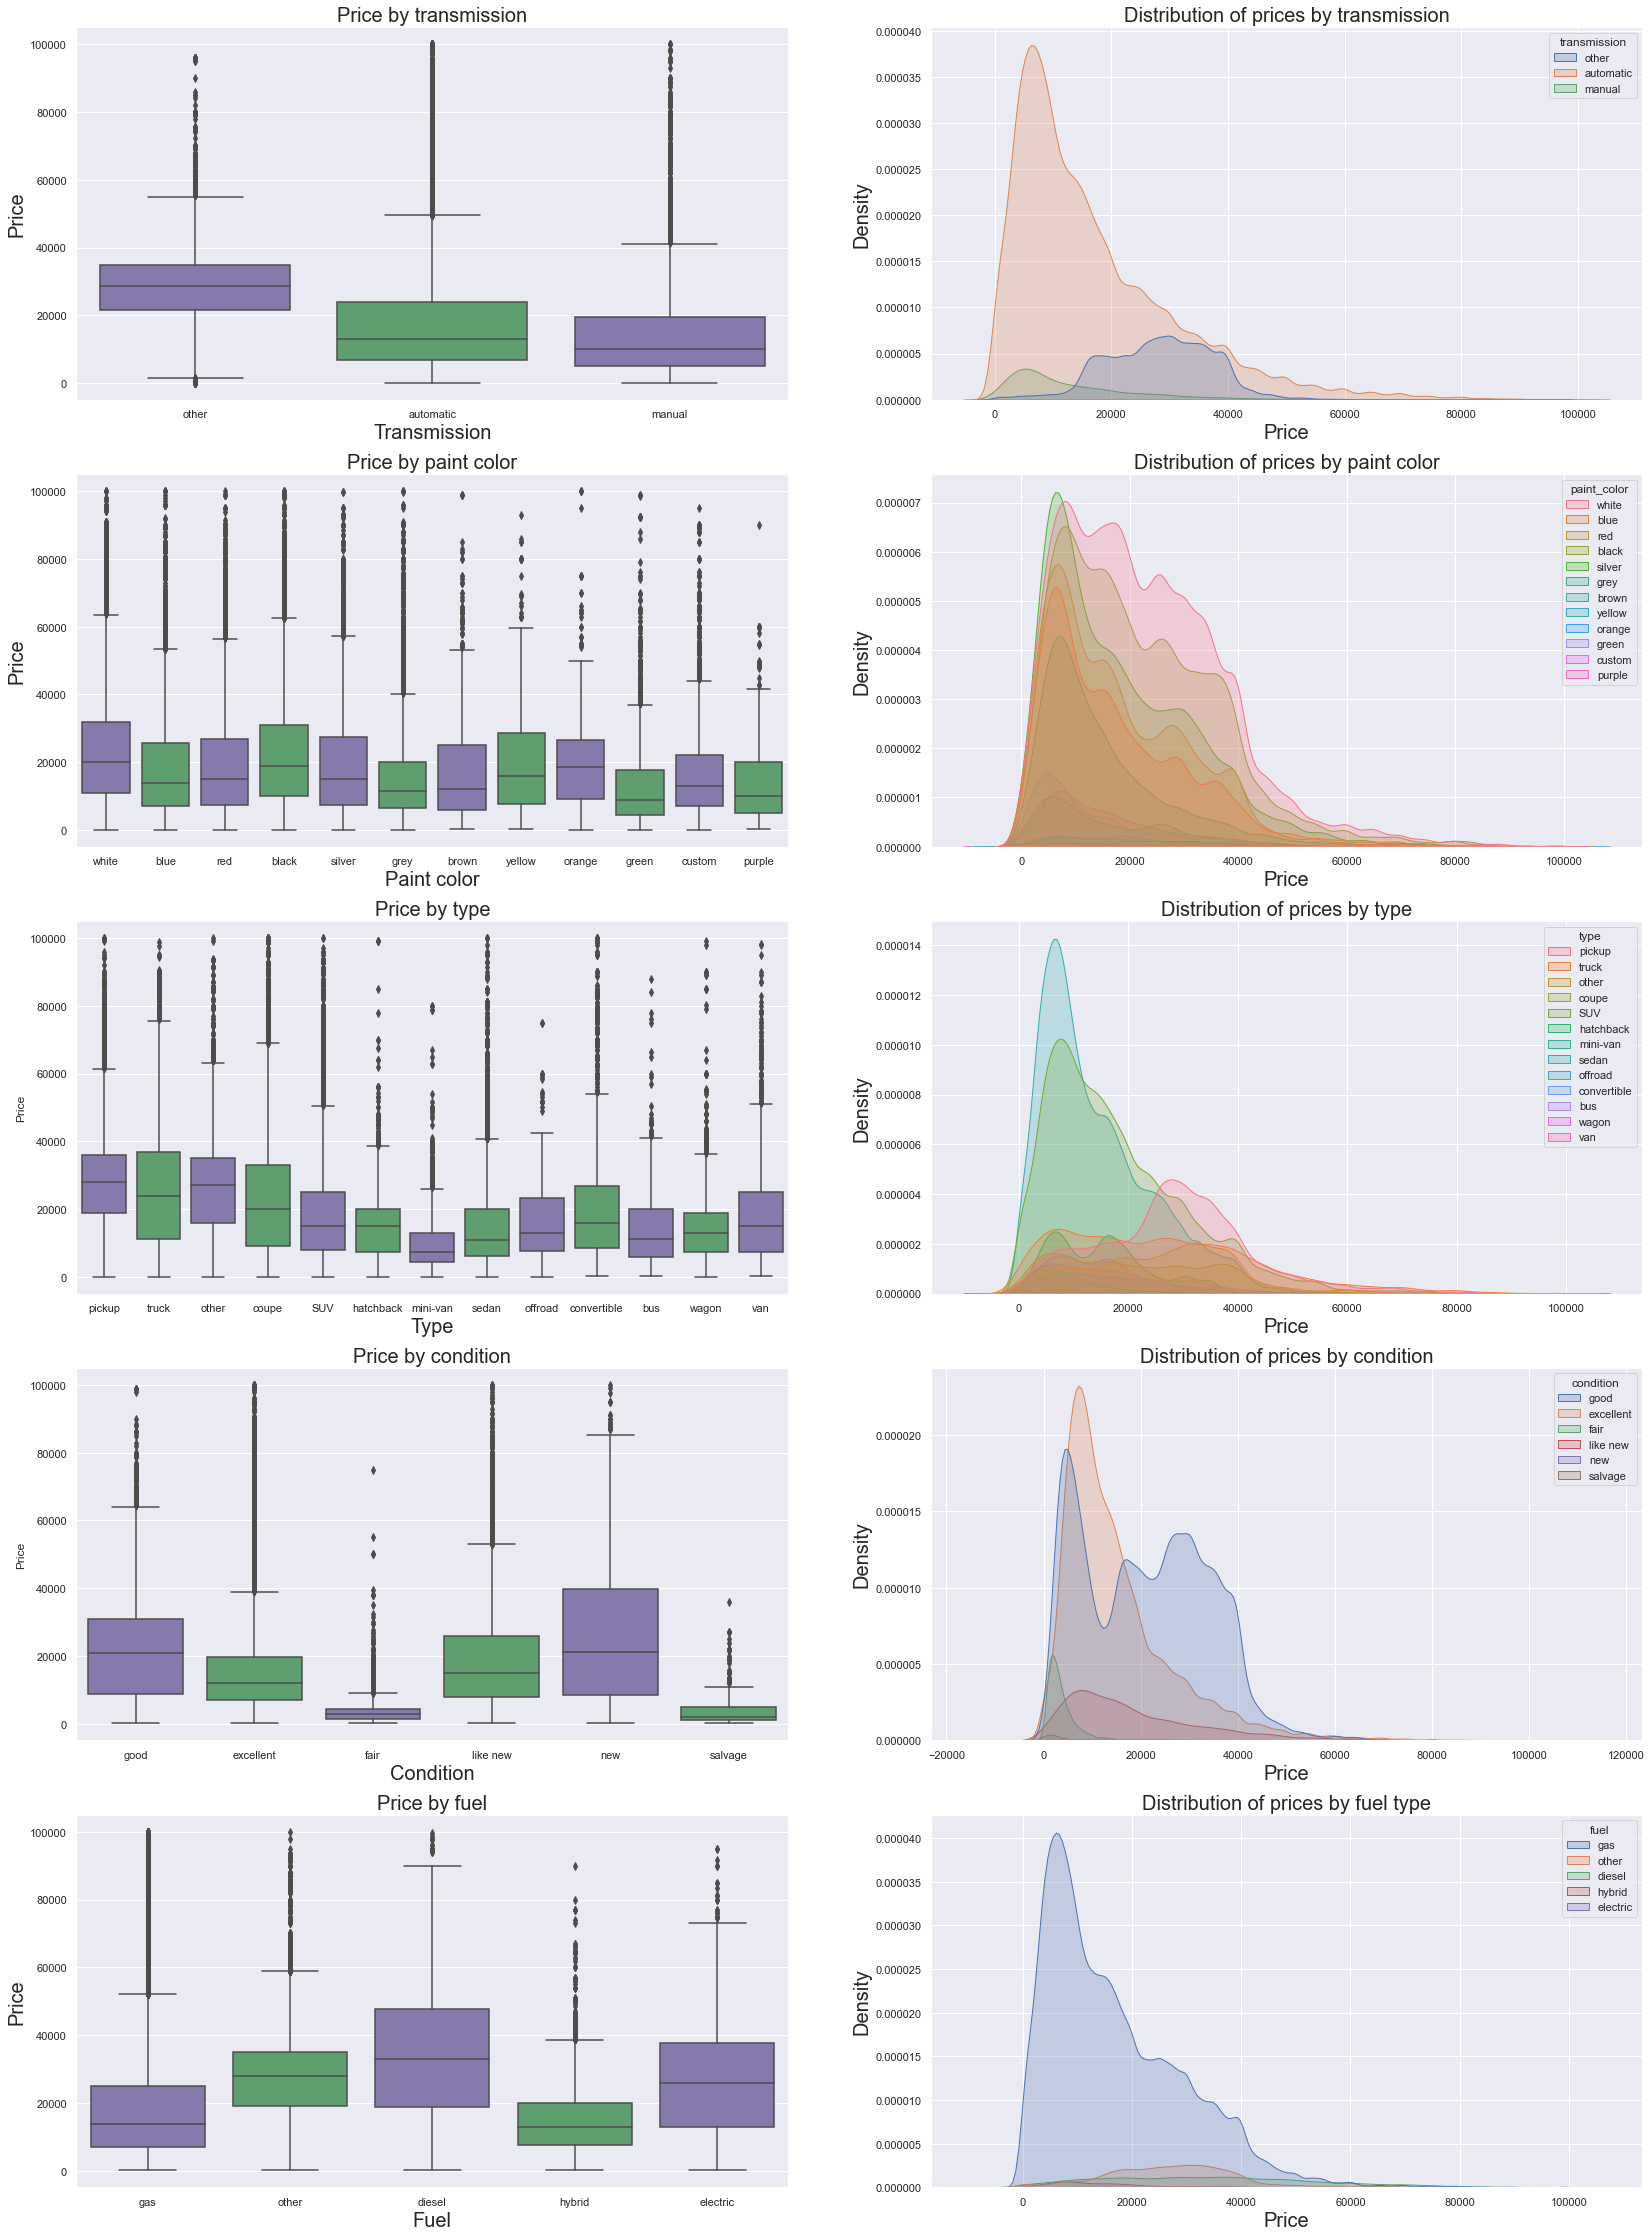

In [8]:
plt.subplot(5, 2, 1)
plt.subplots_adjust(bottom=5, top=7.5)
p = sns.boxplot(
    x="transmission", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by transmission", fontsize=20)
p.set_xlabel("Transmission", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 2)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="transmission", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by transmission", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 3)
p = sns.boxplot(
    x="paint_color", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by paint color", fontsize=20)
p.set_xlabel("Paint color", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 4)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="paint_color", fill=True, data=cars)
p.set_title("Distribution of prices by paint color", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 5)
p = sns.boxplot(
    x="type", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by type", fontsize=20)
p.set_xlabel("Type", fontsize=20)
p.set_ylabel("Price")
plt.subplot(5, 2, 6)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="type", fill=True, data=cars)
p.set_title("Distribution of prices by type", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)

plt.subplot(5, 2, 7)
p = sns.boxplot(
    x="condition", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by condition", fontsize=20)
p.set_xlabel("Condition", fontsize=20)
p.set_ylabel("Price")
plt.subplot(5, 2, 8)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="condition", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by condition", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 9)
p = sns.boxplot(
    x="fuel", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by fuel", fontsize=20)
p.set_xlabel("Fuel", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 10)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="fuel", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by fuel type", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)



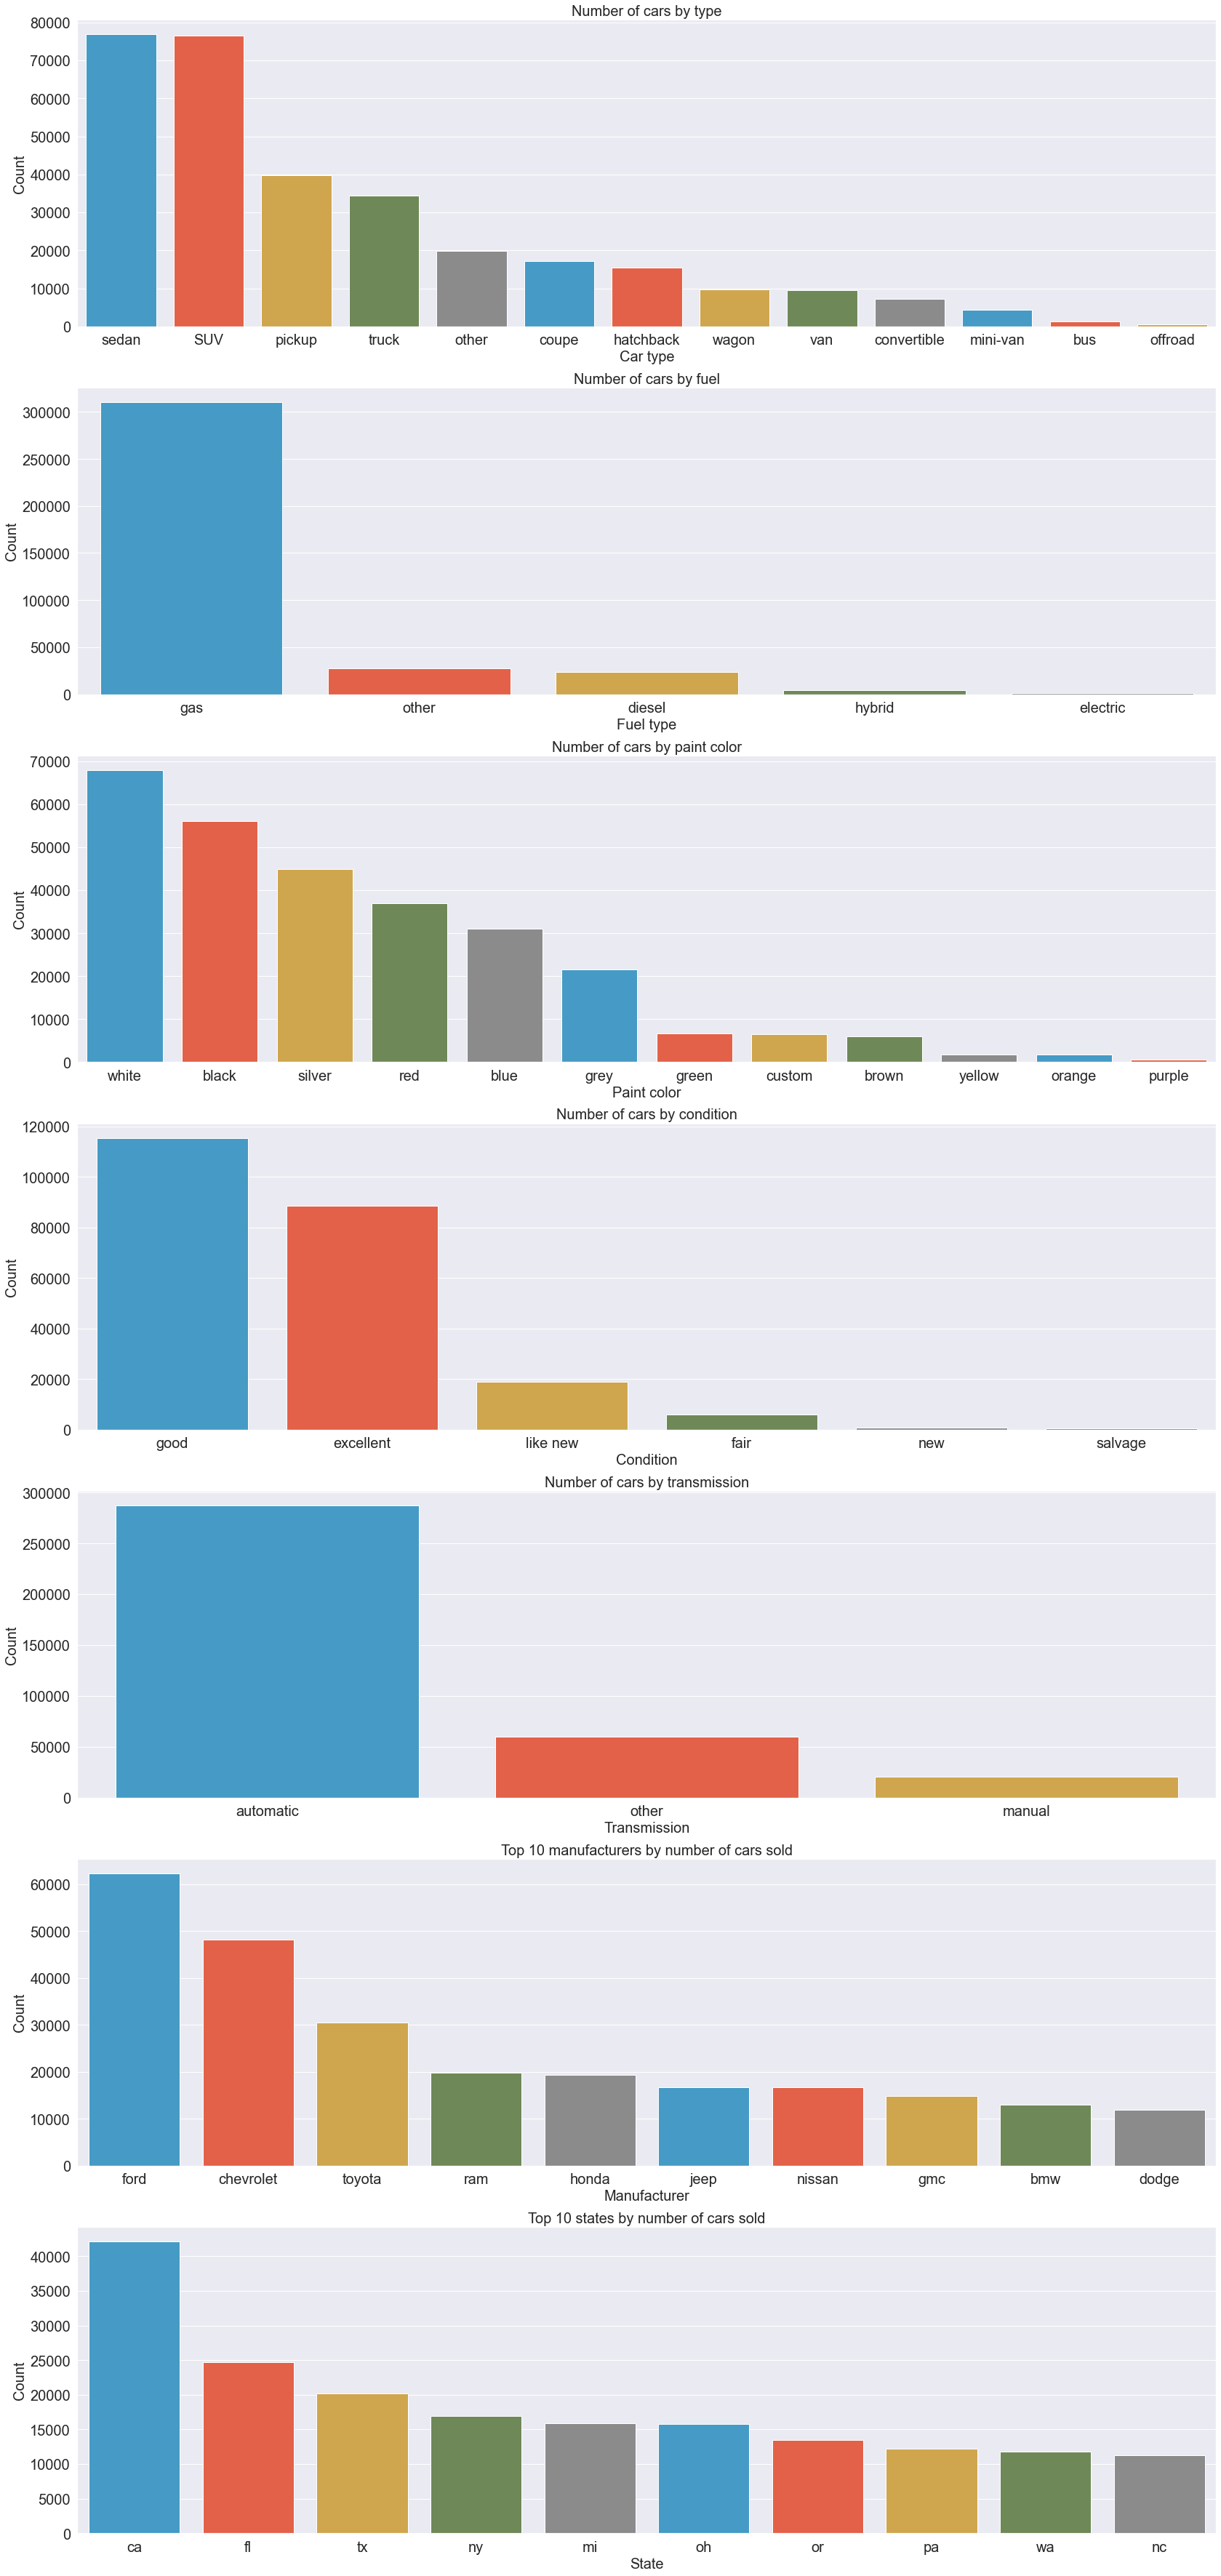

In [9]:
plt.subplots_adjust(bottom=4, top=8)
plt.subplot(7, 1, 1)
p = sns.countplot(
    x="type",
    order=cars["type"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by type", fontsize=20)
p.set_xlabel("Car type", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 2)
p = sns.countplot(
    x="fuel", 
    order=cars["fuel"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by fuel", fontsize=20)
p.set_xlabel("Fuel type", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 3)
p = sns.countplot(
    x="paint_color", 
    order=cars["paint_color"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by paint color", fontsize=20)
p.set_xlabel("Paint color", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 4)
p = sns.countplot(
    x="condition", 
    order=cars["condition"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by condition", fontsize=20)
p.set_xlabel("Condition", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 5)
p = sns.countplot(
    x="transmission", 
    order=cars["transmission"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by transmission", fontsize=20)
p.set_xlabel("Transmission", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)


plt.subplot(7, 1, 6)
p = sns.countplot(
    x="manufacturer", 
    order=cars["manufacturer"].value_counts().iloc[:10].index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Top 10 manufacturers by number of cars sold", fontsize=20)
p.set_xlabel("Manufacturer", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 7)
p = sns.countplot(
    x="state", 
    order=cars["state"].value_counts().iloc[:10].index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Top 10 states by number of cars sold", fontsize=20)
p.set_xlabel("State", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

#### Numerical variables. Are they correlated with price ?

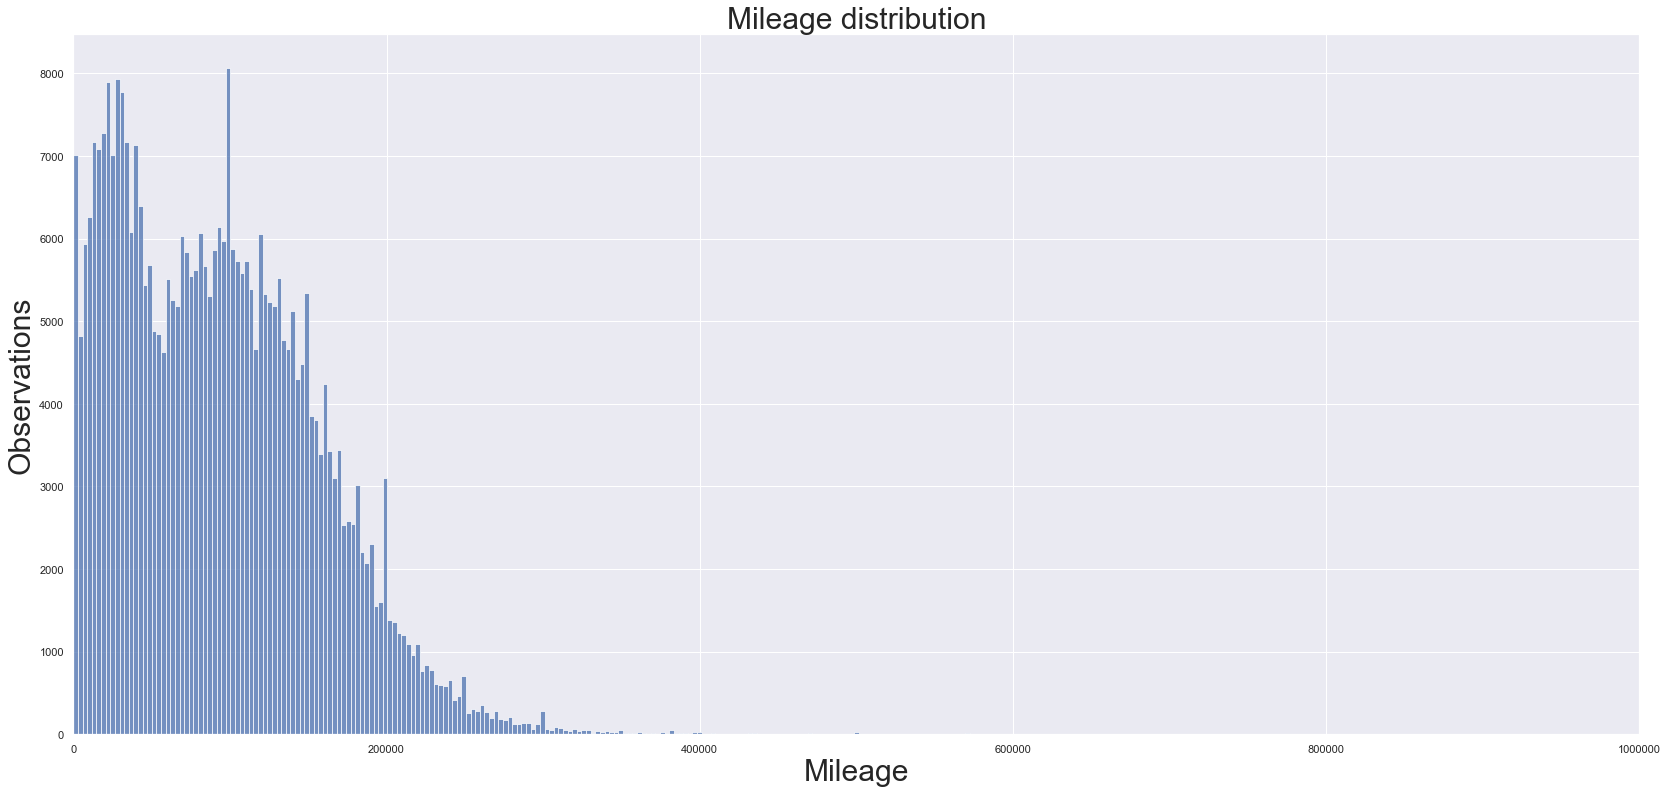

In [10]:
fig, ax = plt.subplots()
p = sns.histplot(cars["odometer"], bins=200)
p.axes.set_title("Mileage distribution",fontsize=30)
p.set_xlabel("Mileage",fontsize=30)
p.set_ylabel("Observations",fontsize=30)
plt.xlim([0, 1000000])
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.show()

Text(0, 0.5, 'Price')

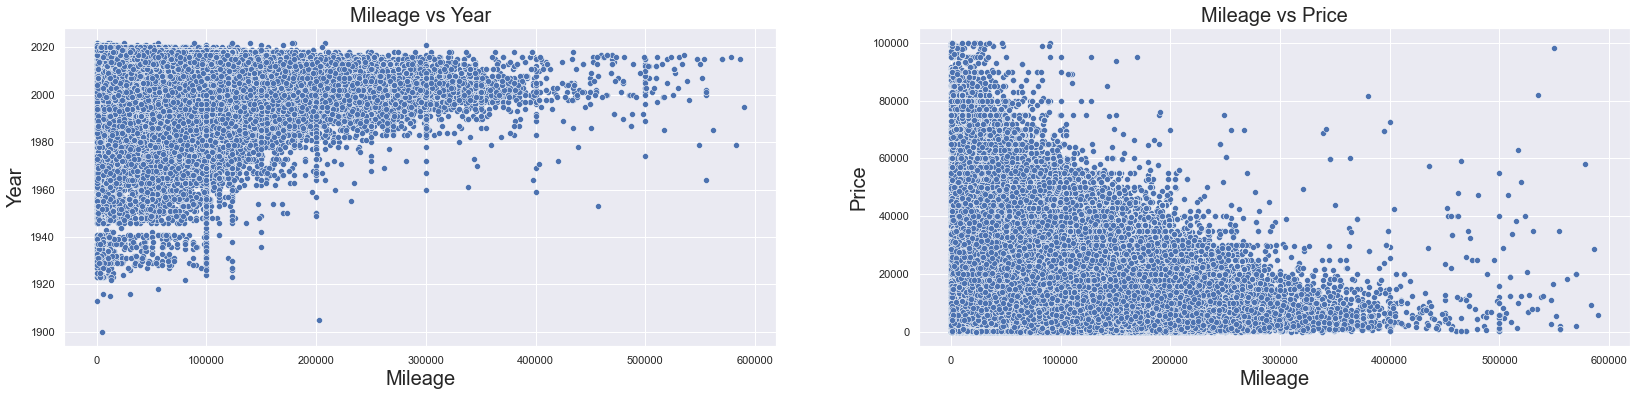

In [11]:
plt.subplot(2, 2, 1)
plt.ticklabel_format(style='plain', axis='x')
p = sns.scatterplot(x="odometer", y="year", data=cars)
p.set_title("Mileage vs Year", fontsize=20)
p.set_xlabel("Mileage", fontsize=20)
p.set_ylabel("Year", fontsize=20)
plt.subplot(2, 2, 2)
plt.ticklabel_format(style='plain', axis='x')
p = sns.scatterplot(x="odometer", y="price", data=cars)
p.set_title("Mileage vs Price", fontsize=20)
p.set_xlabel("Mileage", fontsize=20)
p.set_ylabel("Price", fontsize=20)

<AxesSubplot:>

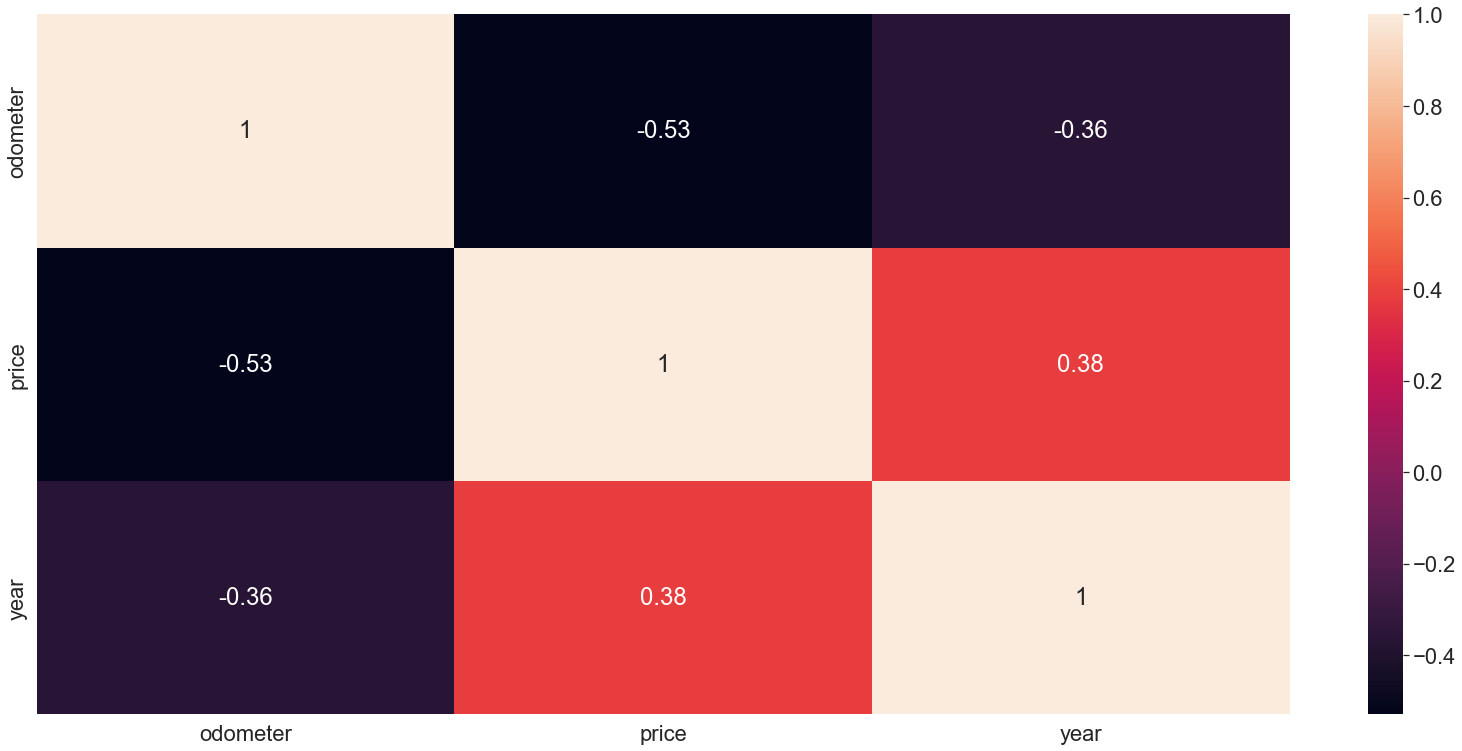

In [12]:
correlation = cars[["odometer", "price", "year"]].corr( method='pearson' )
sns.set(font_scale=2)
sns.heatmap(correlation, annot=True)

Text(0, 0.5, 'Mean price')

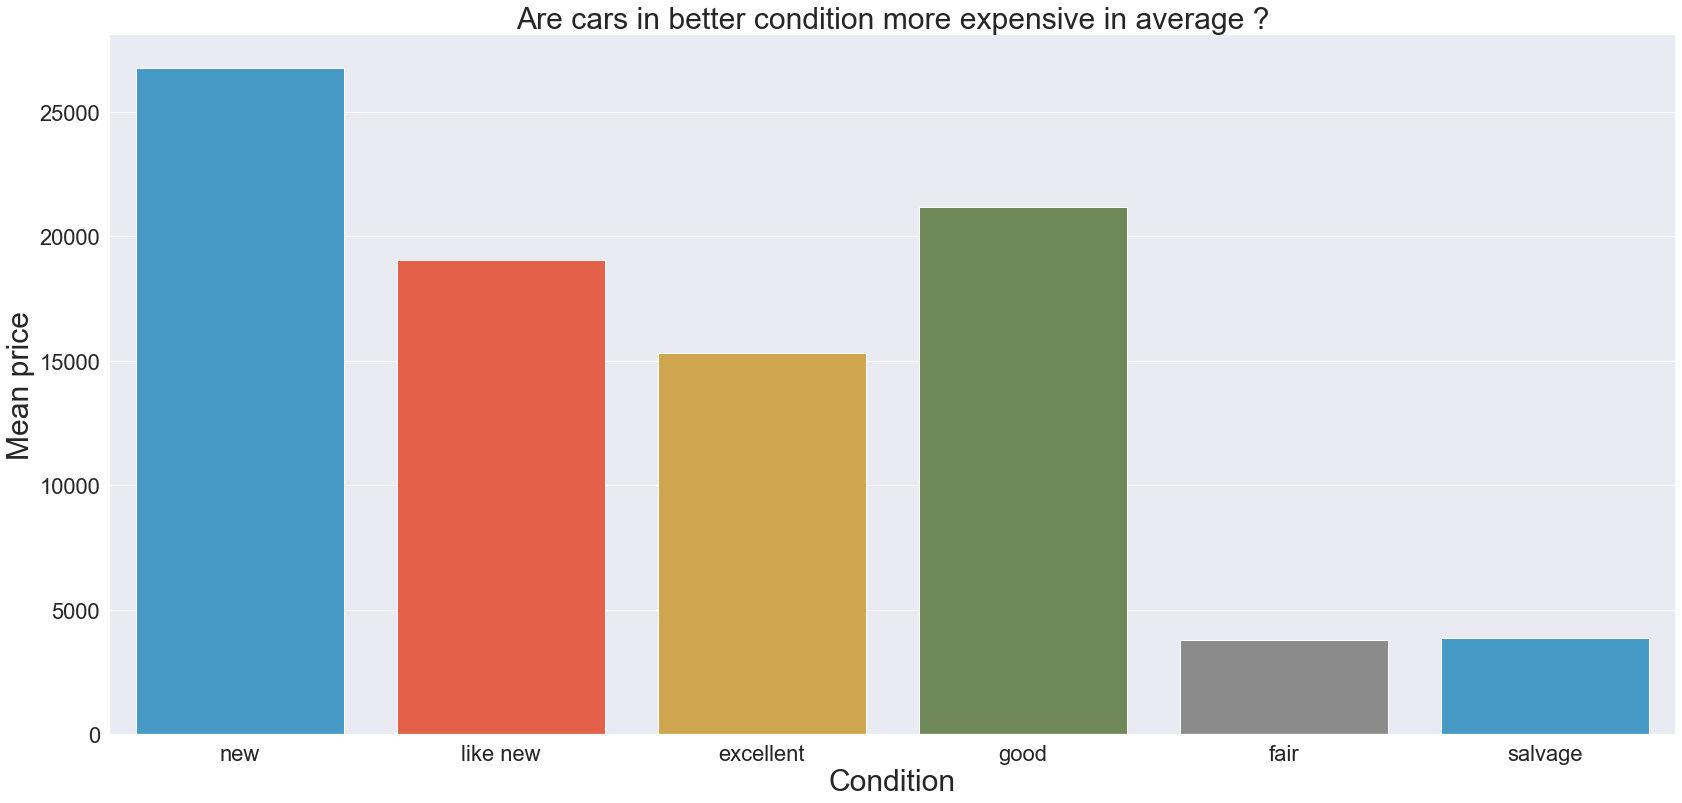

In [13]:
price_by_cond = cars[["condition", "price"]].groupby("condition").mean().reset_index()
p = sns.barplot(
    x="condition",
    y="price",
    order=["new", "like new", "excellent", "good", "fair", "salvage"],
    palette=five_thirty_eight,
    data=price_by_cond,)
p.set_title("Are cars in better condition more expensive in average ?", fontsize=30)
p.set_xlabel("Condition", fontsize=30)
p.set_ylabel("Mean price", fontsize=30)

In order to avoid negative predictions for the price, will model the log price and transform the price back at the end.

In [19]:
cars["logprice"] = np.log(cars["price"])

### Model building

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [32]:
# given the fact that the initial dataset has around 400.000 observations, I think a 10% 
# test dataset should be enough
X_train, X_test, y_train, y_test = train_test_split(cars, cars["logprice"], test_size=0.1)

In [36]:
def get_errors(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
        "Model Name": model_name,
        "MAE": mae,
        "RMSE": rmse
    }, index=[0])

- test_X/test_Y will be used to calculate the generalisation error
- train_X/train_Y will be split further, into a dev-validation used for hyperparameter tunning

##### Baseline model
Dummy model that predicts the average in any situation. Will use this as baseline to compare the rest of the models.

In [41]:
yhat_baseline = np.repeat(y_test.mean(), len(y_test))
baseline_result = get_errors('Average Model', np.exp(y_test), np.exp(yhat_baseline))
baseline_result

,Model Name,MAE,RMSE
0,Average Model,11193.598417,15333.526766
